### Redes Neuronales convolucionales o CNN

Son un tipo de redes neuronales usadas para reconomiento de patrones en imágenes. 

Utilizan capas convolucionales, las cuales se pueden pensar como la aplicación de filtros a las imágenes en búsqueda de algún feature o característica particular en la imágen.

La idea detrás de las redes convolucionales es la contrucción jerárquica de conceptos abstractos que permitan realizar la tarea en cuestión, como la detección de bordes, texturas, contrastes, etc, en las primeras capas y usar esto en las capas más profundas para contruir conceptos como objetos, caras, animales, etc. 

Empezamos con un ejemplo sencillo: la base de datos MNIST de números manuscritos

In [58]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np

In [17]:
mnist = fetch_openml('mnist_784', version=1)
X, Y = mnist["data"], mnist["target"]

Hacemos un reshape de los datos ya que las imágenes vienen en forma de arrays 

In [32]:
X_images = X.reshape(X.shape[0],28,28,1)

In [33]:
X_images.shape

(70000, 28, 28, 1)

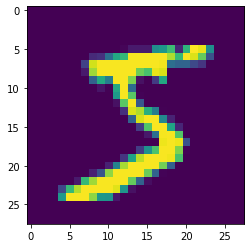

In [35]:
plt.imshow(X_images[0][:,:,0])

In [15]:
Y[0]

'5'

Entrenamos un modelo sencillo

In [36]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.model_selection import train_test_split

img_rows, img_cols = 28, 28
num_clases = 10

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_images, Y, test_size = 0.2, random_state = 42)

hacemos un one hot encode de los labels

In [38]:
y_train[0]

'5'

In [39]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [40]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

Definimos y complilamos nuestro modelo

Normalmente los modelos de CNN tienen en la primera parte los llamados bloques convolucionales, formados por capas convolucionales y capas de pooling, donde las capas convolucionales aplican distintos filtros a las imágenes y las capas de pooling reducen la dimensión de las misma, teniendo por lo tanto imágenes más pequeñas a medida que se avanza en la red.

In [42]:

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=5,
          verbose=0,
          validation_data=(X_test, y_test))


In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)              

el método evaluate() da las métricas del modelos aplicadas al set de datos en cuestion, se puede ver cuales métricas da usando el método metrics_names()

In [44]:
score = model.evaluate(X_test, y_test, verbose=0)
score

[0.048529558901537845, 0.9864285588264465]

In [45]:
model.metrics_names

['loss', 'accuracy']

el modelo obtuvo casi un 97% de accuracy

### Autoencoder

La idea es ahora hacer una red que le saque ruido a las imágenes. Para ello entrenaremos un modelo tipo encoder decoder el cual intenta guardar la mayor cantidad de información en pocas variables y a partir de ello reconstruir la las imágenes.

Es de esperar que haciendo esto la información no relevante que el modelo va a descartar es el ruido de las imágenes.

In [79]:
from keras.layers import Input, Dense
from keras.models import Model 

encoding_dim = 32  

input_img = Input(shape=(784,))

encoded = Dense(encoding_dim, activation='relu')(input_img)

decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [80]:
encoder = Model(input_img, encoded)

In [81]:
encoded_input = Input(shape=(encoding_dim,))

decoder_layer = autoencoder.layers[-1]

decoder = Model(encoded_input, decoder_layer(encoded_input))


In [82]:
autoencoder.compile(optimizer='adadelta', loss='mse')

In [83]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

In [84]:
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [85]:
history = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test), verbose = 0)


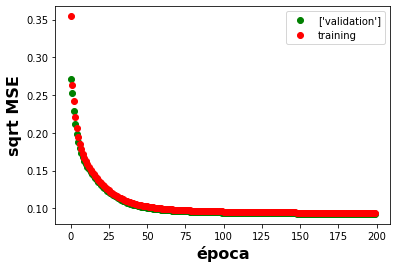

In [86]:
plt.plot(history.history['val_loss'], "og", label=['validation'])
plt.plot(history.history['loss'], "or", label='training')
plt.xlabel("época",  fontsize=16, fontweight = 'bold')
plt.ylabel("sqrt MSE",  fontsize=16, fontweight = 'bold')
plt.legend()

la idea es que una vez entrenado el modelo, metemos como input una imágen y la salida es la misma imágen sin ruido

In [87]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [169]:
image = x_test[449].reshape(28,28)
image_output = decoded_imgs[449].reshape(28,28)

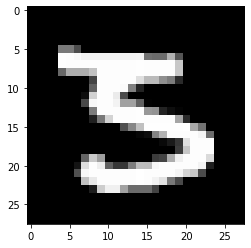

In [170]:
plt.imshow(image)

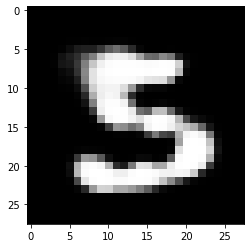

In [171]:
plt.imshow(image_output)

In [179]:
image = x_test[552].reshape(28,28)
image_output = decoded_imgs[552].reshape(28,28)

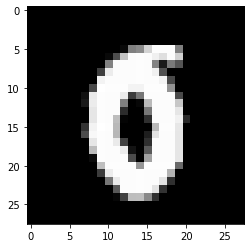

In [180]:
plt.imshow(image)

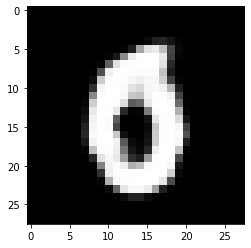

In [181]:
plt.imshow(image_output)

## PyTorch

PyTorch es una libreria que permite hacer modelos más customs, en general lo que se puede hacer en keras se puede hacer en PyTorch pero lo contrario la mayor parte de las veces no es cierto

Hacemos el primer ejemplo pero ahora en PyTorch

In [193]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision

In [194]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [195]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.1,
                      momentum=0.98)